<a href="https://colab.research.google.com/github/TobyHerlong/Finance/blob/main/Currency_Markets_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Python code implements a **Yen Carry Trade strategy** with several sophisticated components:

### What the code does:
*   **Downloads Financial Data**: Fetches historical prices for two assets (e.g., ETFs like EMB and SPY) and the USDJPY exchange rate.
*   **Calculates Basket Returns**: Combines the returns of the two assets based on a fixed allocation (e.g., 85% SPY, 15% EMB).
*   **Implements Dynamic FX Hedging**: Adjusts the exposure to the Yen (shorting JPY) based on whether the USDJPY exchange rate is above or below its 150-day moving average. A lower hedge is applied when USDJPY is trending up (above MA), and a higher hedge when trending down (below MA).
*   **Applies Carry Drift**: Incorporates an annualized carry drift (e.g., 4%) to simulate the interest rate differential.
*   **Regime Filtering**: The strategy is only active when USDJPY is above its 150-day moving average, acting as a trend filter to avoid adverse yen trends.
*   **Volatility Targeting**: Scales the strategy's exposure dynamically to target a specific annualized volatility (e.g., 15%). This helps in maintaining a consistent risk profile over time.
*   **Performance Evaluation**: Calculates and displays various performance metrics (CAGR, volatility, Sharpe Ratio, Max Drawdown) for the strategy, the unhedged asset basket, and individual assets.
*   **Visualizes Results**: Generates equity curve and drawdown charts to visually represent the strategy's performance.

### Key Aspects:
*   **Risk Management**: Focuses on managing risk through dynamic FX hedging, regime filtering, and especially volatility targeting, which aims to keep the strategy's risk level stable.
*   **Adaptive Strategy**: Unlike a static buy-and-hold, this strategy adapts to market conditions (USDJPY trend, portfolio volatility) to optimize returns.
*   **Comparison**: Provides a clear comparison against a simple unhedged basket, highlighting the value-add of the implemented features.




               YEN CARRY TRADE - DYNAMIC HEDGE & VOL TARGETING
                  70% SPY + 30% EMB + Dynamic FX Hedge

DOWNLOADING DATA - SIMPLIFIED YEN CARRY STRATEGY
Date range: 2010-01-01 to 2025-11-16
Asset 1: EMB
Asset 2: SPY
Currency: JPY=X

â Downloaded EMB: 3993 days
â Downloaded SPY: 3993 days
â Downloaded JPY=X: 4133 days

â Final dataset: 4138 trading days
â Date range: 2010-01-04 to 2025-11-14

COMPUTING FEATURES
â Computed returns for EMB, SPY, and USDJPY
â Basket: 85% SPY + 15% EMB
â Carry drift: 4.00% annualized (0.000159 daily)

--------------------------------------------------------------------------------
REGIME FILTER & DYNAMIC FX HEDGE
--------------------------------------------------------------------------------
â USDJPY > 150-day MA: active 52.7% of time
â Dynamic FX hedge: 20% when above MA, 60% when below MA
  Average hedge ratio: 38.9%
  % time at 20% hedge: 52.7%

BUILDING STRATEGY
Target volatility: 15.0%
Exposure range: 1.0x - 2.0x
Vo

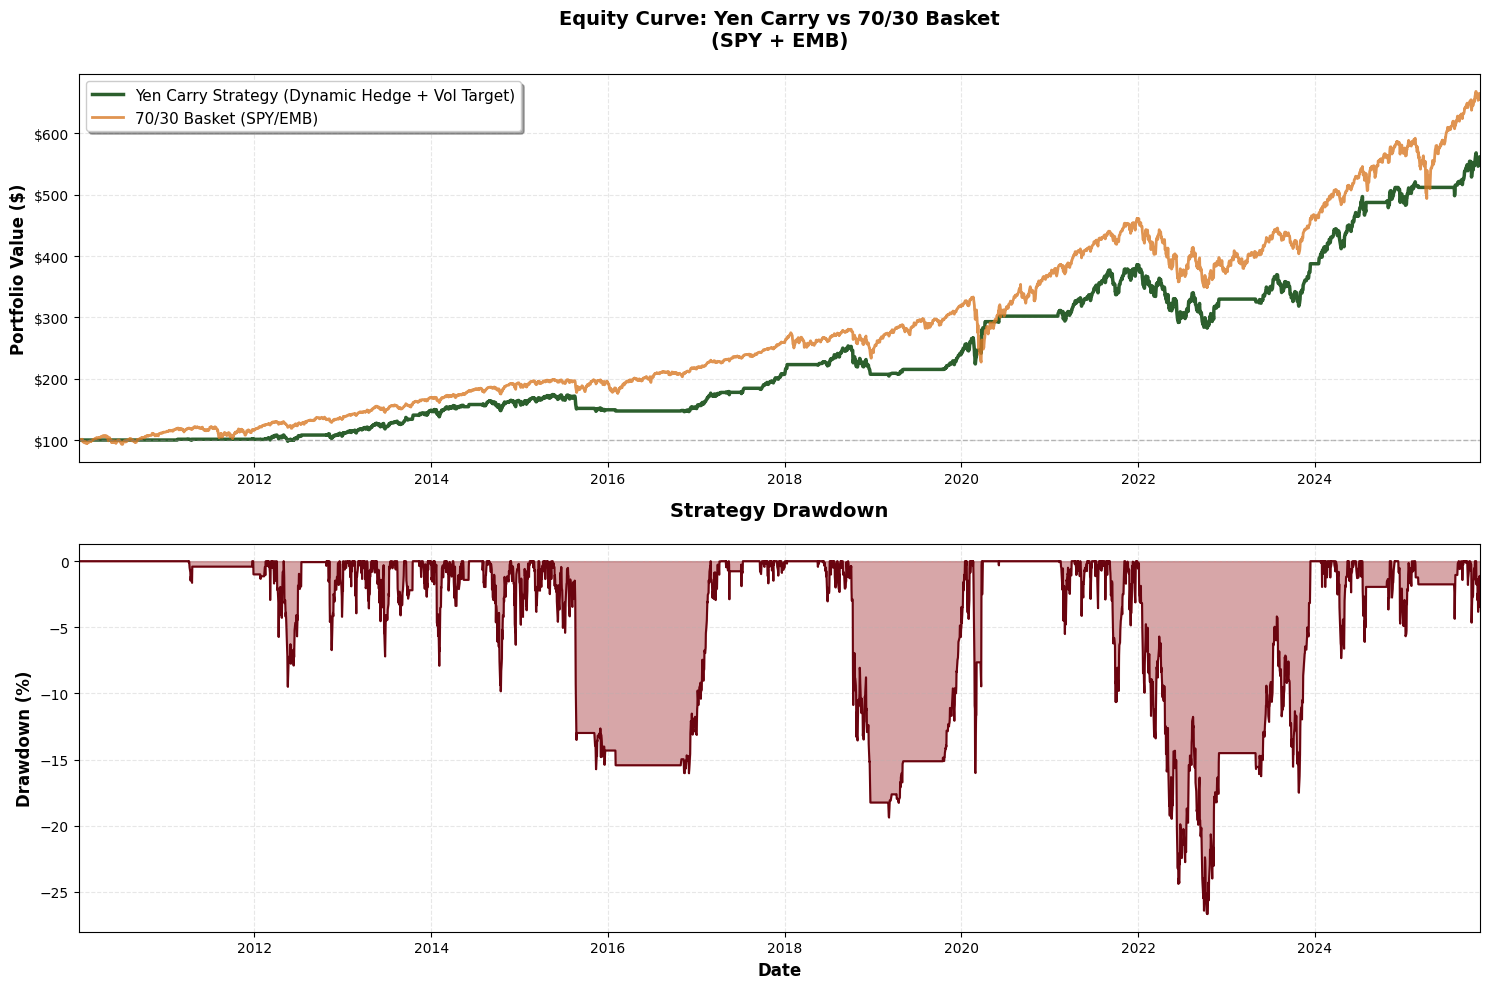

                              BACKTEST COMPLETE



In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================
# Fixed allocation
ASSET_1 = "EMB"  # Broad EM ETF (UPDATED from EEM)
ASSET_2 = "SPY"  # US equities
ALLOCATION_1 = 0.15  # 15% to EMB (UPDATED from 20%)
ALLOCATION_2 = 0.85  # 85% to SPY (UPDATED from 80%)

JPY_TICKER = "JPY=X"
START_DATE = "2010-01-01"
END_DATE = datetime.today().strftime('%Y-%m-%d')

# Strategy parameters
CARRY_DRIFT = 0.04  # 4% annualized carry drift

# Dynamic FX hedge based on USDJPY trend
FX_HEDGE_ABOVE_MA = 0.2  # 20% hedge when USDJPY > 200-day MA
FX_HEDGE_BELOW_MA = 0.6  # 60% hedge when USDJPY < 200-day MA

# Regime filter
MA_WINDOW = 150  # 150-day moving average

# Volatility targeting (NEW)
TARGET_VOL = 0.15  # 15% annualized volatility target
MIN_EXPOSURE = 1.0  # Minimum exposure floor (UPDATED from 0.8)
MAX_EXPOSURE = 2.0  # Maximum exposure cap (Confirmed at 2.0)
VOL_LOOKBACK = 60  # 60-day lookback for volatility calculation

# ============================================================================
# 1. DATA DOWNLOAD
# ============================================================================
def download_data(asset1, asset2, jpy_ticker, start=START_DATE, end=END_DATE):
    """
    Download price data for two assets and USDJPY.

    Parameters:
    -----------
    asset1 : str
        First asset ticker (e.g., 'EWZ')
    asset2 : str
        Second asset ticker (e.g., 'SPY')
    jpy_ticker : str
        JPY ticker (typically 'JPY=X')
    start : str
        Start date
    end : str
        End date

    Returns:
    --------
    pd.DataFrame
        DataFrame with prices for all assets
    """
    print("=" * 80)
    print("DOWNLOADING DATA - SIMPLIFIED YEN CARRY STRATEGY")
    print("=" * 80)
    print(f"Date range: {start} to {end}")
    print(f"Asset 1: {asset1}")
    print(f"Asset 2: {asset2}")
    print(f"Currency: {jpy_ticker}\n")

    # Download asset 1
    try:
        data1 = yf.download(asset1, start=start, end=end, progress=False)
        price1 = data1['Adj Close'] if 'Adj Close' in data1.columns else data1['Close']
        if isinstance(price1, pd.DataFrame):
            price1 = price1.iloc[:, 0]
        print(f"â Downloaded {asset1}: {len(price1)} days")
    except Exception as e:
        print(f"â Failed to download {asset1}: {str(e)}")
        raise

    # Download asset 2
    try:
        data2 = yf.download(asset2, start=start, end=end, progress=False)
        price2 = data2['Adj Close'] if 'Adj Close' in data2.columns else data2['Close']
        if isinstance(price2, pd.DataFrame):
            price2 = price2.iloc[:, 0]
        print(f"â Downloaded {asset2}: {len(price2)} days")
    except Exception as e:
        print(f"â Failed to download {asset2}: {str(e)}")
        raise

    # Download USDJPY
    try:
        jpy_data = yf.download(jpy_ticker, start=start, end=end, progress=False)
        jpy_price = jpy_data['Adj Close'] if 'Adj Close' in jpy_data.columns else jpy_data['Close']
        if isinstance(jpy_price, pd.DataFrame):
            jpy_price = jpy_price.iloc[:, 0]
        print(f"â Downloaded {jpy_ticker}: {len(jpy_price)} days")
    except Exception as e:
        print(f"â Failed to download {jpy_ticker}: {str(e)}")
        raise

    # Combine into DataFrame
    df = pd.DataFrame({
        f'price_{asset1}': price1,
        f'price_{asset2}': price2,
        'usdjpy': jpy_price
    })

    # Forward fill and drop NaN
    df = df.fillna(method='ffill').dropna()

    print(f"\nâ Final dataset: {len(df)} trading days")
    print(f"â Date range: {df.index[0].date()} to {df.index[-1].date()}\n")

    return df

# ============================================================================
# 2. FEATURE COMPUTATION
# ============================================================================
def compute_features(df, asset1, asset2, alloc1=ALLOCATION_1, alloc2=ALLOCATION_2,
                     carry_drift=CARRY_DRIFT, ma_window=MA_WINDOW,
                     fx_hedge_above=FX_HEDGE_ABOVE_MA, fx_hedge_below=FX_HEDGE_BELOW_MA):
    """
    Compute returns, basket allocation, regime filter, and dynamic FX hedge.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with price data
    asset1 : str
        First asset ticker
    asset2 : str
        Second asset ticker
    alloc1 : float
        Allocation to asset 1
    alloc2 : float
        Allocation to asset 2
    carry_drift : float
        Annualized carry drift
    ma_window : int
        Moving average window
    fx_hedge_above : float
        FX hedge ratio when USDJPY > MA
    fx_hedge_below : float
        FX hedge ratio when USDJPY < MA

    Returns:
    --------
    pd.DataFrame
        DataFrame with computed features
    """
    print("=" * 80)
    print("COMPUTING FEATURES")
    print("=" * 80)

    # Calculate returns
    df[f'ret_{asset1}'] = df[f'price_{asset1}'].pct_change()
    df[f'ret_{asset2}'] = df[f'price_{asset2}'].pct_change()
    df['usdjpy_ret'] = df['usdjpy'].pct_change()

    print(f"â Computed returns for {asset1}, {asset2}, and USDJPY")

    # Fixed basket allocation
    df['basket_ret'] = alloc1 * df[f'ret_{asset1}'] + alloc2 * df[f'ret_{asset2}']
    print(f"â Basket: {alloc2:.0%} {asset2} + {alloc1:.0%} {asset1}")

    # Carry drift (daily)
    df['carry_drift_daily'] = carry_drift / 252
    print(f"â Carry drift: {carry_drift:.2%} annualized ({carry_drift/252:.6f} daily)")

    # ========================================================================
    # REGIME FILTER: USDJPY > 200-day MA
    # ========================================================================
    print("\n" + "-" * 80)
    print("REGIME FILTER & DYNAMIC FX HEDGE")
    print("-" * 80)

    df['usdjpy_ma200'] = df['usdjpy'].rolling(ma_window).mean()
    df['regime_ok'] = (df['usdjpy'] > df['usdjpy_ma200']).astype(int)

    regime_pct = df['regime_ok'].mean()
    print(f"â USDJPY > {ma_window}-day MA: active {regime_pct:.1%} of time")

    # ========================================================================
    # DYNAMIC FX HEDGE
    # ========================================================================
    # When USDJPY > MA (bullish trend): use lower hedge (25%)
    # When USDJPY < MA (bearish trend): use higher hedge (75%)
    df['fx_hedge_ratio'] = np.where(
        df['usdjpy'] > df['usdjpy_ma200'],
        fx_hedge_above,
        fx_hedge_below
    )

    avg_hedge = df['fx_hedge_ratio'].mean()
    pct_low_hedge = (df['fx_hedge_ratio'] == fx_hedge_above).mean()
    print(f"â Dynamic FX hedge: {fx_hedge_above:.0%} when above MA, {fx_hedge_below:.0%} when below MA")
    print(f"  Average hedge ratio: {avg_hedge:.1%}")
    print(f"  % time at {fx_hedge_above:.0%} hedge: {pct_low_hedge:.1%}")

    print()

    return df

# ============================================================================
# 3. STRATEGY CONSTRUCTION
# ============================================================================
def build_strategy(df, asset1, asset2, target_vol=TARGET_VOL,
                   min_exposure=MIN_EXPOSURE, max_exposure=MAX_EXPOSURE,
                   vol_lookback=VOL_LOOKBACK):
    """
    Build the carry trade strategy with dynamic FX hedge, regime filtering,
    and volatility targeting.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with features
    asset1 : str
        First asset ticker
    asset2 : str
        Second asset ticker
    target_vol : float
        Target annualized volatility
    min_exposure : float
        Minimum exposure floor
    max_exposure : float
        Maximum exposure cap
    vol_lookback : int
        Lookback period for volatility calculation

    Returns:
    --------
    pd.DataFrame
        DataFrame with strategy returns
    """
    print("=" * 80)
    print("BUILDING STRATEGY")
    print("=" * 80)
    print(f"Target volatility: {target_vol:.1%}")
    print(f"Exposure range: {min_exposure:.1f}x - {max_exposure:.1f}x")
    print(f"Vol lookback: {vol_lookback} days")
    print("Strategy: basket_return - (dynamic_fx_hedge Ã USDJPY_return) + carry_drift\n")

    # Raw strategy return with DYNAMIC FX hedge
    # Long basket, dynamic short JPY = basket return - (fx_hedge_ratio * USDJPY return) + carry drift
    df['raw_strategy_ret'] = (df['basket_ret'] -
                              df['fx_hedge_ratio'] * df['usdjpy_ret'] +
                              df['carry_drift_daily'])

    print("â Computing raw strategy returns with dynamic FX hedge")

    # ========================================================================
    # VOLATILITY TARGETING
    # ========================================================================
    print("\nApplying volatility targeting...")

    # Calculate realized portfolio volatility
    df['portfolio_vol'] = df['raw_strategy_ret'].rolling(vol_lookback).std() * np.sqrt(252)

    # Volatility scaling factor (target vol / realized vol)
    df['vol_scale'] = target_vol / df['portfolio_vol']
    df['vol_scale'] = df['vol_scale'].clip(lower=min_exposure, upper=max_exposure)
    df['vol_scale'] = df['vol_scale'].fillna(1.0)  # Use 1.0 before enough history

    print(f"â Volatility scaling computed")

    # ========================================================================
    # APPLY REGIME FILTER AND VOL TARGETING
    # ========================================================================

    # Initialize exposure
    df['base_exposure'] = 0.0  # Before vol targeting
    df['final_exposure'] = 0.0  # After vol targeting
    df['strategy_ret'] = 0.0

    print("\nApplying regime filter and vol targeting...")

    for i in range(1, len(df)):
        # Check regime filter only (no exit signal)
        if df['regime_ok'].iloc[i] == 1:
            # Apply volatility targeting
            base_exposure = 1.0
            final_exposure = base_exposure * df['vol_scale'].iloc[i]
        else:
            # No exposure outside regime
            base_exposure = 0.0
            final_exposure = 0.0

        df.loc[df.index[i], 'base_exposure'] = base_exposure
        df.loc[df.index[i], 'final_exposure'] = final_exposure

    # Calculate actual strategy returns using final exposure
    df['strategy_ret'] = df['raw_strategy_ret'] * df['final_exposure'].shift(1)
    df['strategy_ret'] = df['strategy_ret'].fillna(0)

    # Cumulative returns
    df['basket_cumret'] = (1 + df['basket_ret']).cumprod() - 1
    df['strategy_cumret'] = (1 + df['strategy_ret']).cumprod() - 1

    # Calculate statistics
    avg_base_exposure = df['base_exposure'].mean()
    avg_final_exposure = df['final_exposure'].mean()
    avg_vol_scale = df['vol_scale'].mean()
    pct_invested = (df['base_exposure'] > 0).sum() / len(df)

    print(f"â Strategy construction complete")
    print(f"â Average base exposure: {avg_base_exposure:.2f}x")
    print(f"â Average final exposure (vol-scaled): {avg_final_exposure:.2f}x")
    print(f"â Average vol scale: {avg_vol_scale:.2f}x")
    print(f"â % time invested: {pct_invested:.1%}\n")

    return df

# ============================================================================
# 4. PERFORMANCE STATISTICS
# ============================================================================
def perf_stats(df, asset1, asset2):
    """
    Calculate and display performance statistics.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with strategy returns
    asset1 : str
        First asset ticker
    asset2 : str
        Second asset ticker

    Returns:
    --------
    dict
        Dictionary of performance metrics
    """
    print("=" * 80)
    print("PERFORMANCE STATISTICS")
    print("=" * 80)

    # Filter out NaN values
    strategy_rets = df['strategy_ret'].dropna()
    basket_rets = df['basket_ret'].dropna()

    # Time period
    n_days = len(strategy_rets)
    n_years = n_days / 252

    # ========================================================================
    # STRATEGY PERFORMANCE
    # ========================================================================

    # CAGR
    total_ret_strategy = (1 + strategy_rets).prod() - 1
    cagr_strategy = (1 + total_ret_strategy) ** (1/n_years) - 1 if n_years > 0 else 0

    # Volatility
    vol_strategy = strategy_rets.std() * np.sqrt(252)

    # Sharpe Ratio
    sharpe_strategy = cagr_strategy / vol_strategy if vol_strategy > 0 else 0

    # Max Drawdown
    cumulative = (1 + strategy_rets).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_dd_strategy = drawdown.min()

    # Drawdown series for plotting
    df['drawdown'] = drawdown

    # Win/Loss Statistics
    winning_days = strategy_rets[strategy_rets > 0]
    losing_days = strategy_rets[strategy_rets < 0]

    hit_rate = len(winning_days) / len(strategy_rets[strategy_rets != 0]) if len(strategy_rets[strategy_rets != 0]) > 0 else 0
    avg_win = winning_days.mean() if len(winning_days) > 0 else 0
    avg_loss = losing_days.mean() if len(losing_days) > 0 else 0
    win_loss_ratio = abs(avg_win / avg_loss) if avg_loss != 0 else 0

    # ========================================================================
    # BENCHMARK PERFORMANCE (50/50 Basket)
    # ========================================================================

    total_ret_basket = (1 + basket_rets).prod() - 1
    cagr_basket = (1 + total_ret_basket) ** (1/n_years) - 1 if n_years > 0 else 0
    vol_basket = basket_rets.std() * np.sqrt(252)
    sharpe_basket = cagr_basket / vol_basket if vol_basket > 0 else 0

    cumulative_basket = (1 + basket_rets).cumprod()
    running_max_basket = cumulative_basket.expanding().max()
    drawdown_basket = (cumulative_basket - running_max_basket) / running_max_basket
    max_dd_basket = drawdown_basket.min()

    # ========================================================================
    # INDIVIDUAL ASSET PERFORMANCE
    # ========================================================================

    # Asset 1
    ret1 = df[f'ret_{asset1}'].dropna()
    total_ret1 = (1 + ret1).prod() - 1
    cagr1 = (1 + total_ret1) ** (1/n_years) - 1 if n_years > 0 else 0
    vol1 = ret1.std() * np.sqrt(252)
    sharpe1 = cagr1 / vol1 if vol1 > 0 else 0

    # Asset 2
    ret2 = df[f'ret_{asset2}'].dropna()
    total_ret2 = (1 + ret2).prod() - 1
    cagr2 = (1 + total_ret2) ** (1/n_years) - 1 if n_years > 0 else 0
    vol2 = ret2.std() * np.sqrt(252)
    sharpe2 = cagr2 / vol2 if vol2 > 0 else 0

    # ========================================================================
    # PRINT RESULTS
    # ========================================================================

    print(f"\n{'STRATEGY: YEN CARRY TRADE (DYNAMIC HEDGE + VOL TARGET)':<50}")
    print(f"{'70% SPY + 30% EEM, Dynamic FX Hedge, 12% Vol Target':<50}")
    print("-" * 80)
    print(f"{'Annualized Return (CAGR)':<50} {cagr_strategy:>12.2%}")
    print(f"{'Annualized Volatility':<50} {vol_strategy:>12.2%}")
    print(f"{'Sharpe Ratio':<50} {sharpe_strategy:>12.2f}")
    print(f"{'Maximum Drawdown':<50} {max_dd_strategy:>12.2%}")
    print(f"{'Total Return':<50} {total_ret_strategy:>12.2%}")

    print(f"\n{'WIN/LOSS STATISTICS':<50}")
    print("-" * 80)
    print(f"{'Hit Rate (% winning days)':<50} {hit_rate:>12.2%}")
    print(f"{'Average Win':<50} {avg_win:>12.4%}")
    print(f"{'Average Loss':<50} {avg_loss:>12.4%}")
    print(f"{'Win/Loss Ratio':<50} {win_loss_ratio:>12.2f}")

    print(f"\n{'BENCHMARK: 70/30 BASKET (UNHEDGED)':<50}")
    print("-" * 80)
    print(f"{'Annualized Return (CAGR)':<50} {cagr_basket:>12.2%}")
    print(f"{'Annualized Volatility':<50} {vol_basket:>12.2%}")
    print(f"{'Sharpe Ratio':<50} {sharpe_basket:>12.2f}")
    print(f"{'Maximum Drawdown':<50} {max_dd_basket:>12.2%}")
    print(f"{'Total Return':<50} {total_ret_basket:>12.2%}")

    print(f"\n{'INDIVIDUAL ASSET PERFORMANCE':<50}")
    print("-" * 80)
    print(f"{'Asset':<15} {'CAGR':>12} {'Volatility':>12} {'Sharpe':>12}")
    print("-" * 80)
    print(f"{asset1:<15} {cagr1:>11.2%} {vol1:>11.2%} {sharpe1:>12.2f}")
    print(f"{asset2:<15} {cagr2:>11.2%} {vol2:>11.2%} {sharpe2:>12.2f}")

    print("\n" + "=" * 80 + "\n")

    # Return stats dictionary
    stats = {
        'cagr': cagr_strategy,
        'volatility': vol_strategy,
        'sharpe': sharpe_strategy,
        'max_drawdown': max_dd_strategy,
        'total_return': total_ret_strategy,
        'hit_rate': hit_rate,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'win_loss_ratio': win_loss_ratio
    }

    return stats

# ============================================================================
# 5. PLOTTING
# ============================================================================
def plot_results(df, asset1, asset2):
    """
    Create equity curve and drawdown charts.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with returns and drawdowns
    asset1 : str
        First asset ticker
    asset2 : str
        Second asset ticker
    """
    print("=" * 80)
    print("GENERATING CHARTS")
    print("=" * 80)

    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # ========================================================================
    # EQUITY CURVE
    # ========================================================================
    ax1 = axes[0]
    ax1.plot(df.index, (1 + df['strategy_cumret']) * 100,
             label='Yen Carry Strategy (Dynamic Hedge + Vol Target)', linewidth=2.5, color='#2C5F2D')
    ax1.plot(df.index, (1 + df['basket_cumret']) * 100,
             label=f'70/30 Basket ({asset2}/{asset1})', linewidth=2, color='#D97925', alpha=0.8)

    ax1.axhline(y=100, color='gray', linestyle='--', linewidth=1, alpha=0.5)

    ax1.set_ylabel('Portfolio Value ($)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Equity Curve: Yen Carry vs 70/30 Basket\n({asset2} + {asset1})',
                  fontsize=14, fontweight='bold', pad=20)
    ax1.legend(loc='upper left', fontsize=11, frameon=True, shadow=True, fancybox=True)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_xlim(df.index[0], df.index[-1])

    # Format y-axis
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:.0f}'))

    # ========================================================================
    # DRAWDOWN
    # ========================================================================
    ax2 = axes[1]
    ax2.fill_between(df.index, df['drawdown'] * 100, 0,
                     alpha=0.4, color='#9B2226', label='Drawdown')
    ax2.plot(df.index, df['drawdown'] * 100,
             linewidth=1.5, color='#6A040F')

    ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Drawdown (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Strategy Drawdown', fontsize=14, fontweight='bold', pad=20)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_xlim(df.index[0], df.index[-1])

    plt.tight_layout()

    # Save figure
    filename = 'yen_carry_dynamic_hedge_performance.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"â Chart saved: {filename}\n")

    plt.show()

# ============================================================================
# 6. MAIN EXECUTION
# ============================================================================
def main():
    """
    Main execution function.
    """
    print("\n" + "=" * 80)
    print(" " * 15 + "YEN CARRY TRADE - DYNAMIC HEDGE & VOL TARGETING")
    print(" " * 18 + f"70% {ASSET_2} + 30% {ASSET_1} + Dynamic FX Hedge")
    print("=" * 80 + "\n")

    # Step 1: Download data
    df = download_data(ASSET_1, ASSET_2, JPY_TICKER, START_DATE, END_DATE)

    # Step 2: Compute features
    df = compute_features(df, ASSET_1, ASSET_2,
                         alloc1=ALLOCATION_1, alloc2=ALLOCATION_2,
                         carry_drift=CARRY_DRIFT, ma_window=MA_WINDOW,
                         fx_hedge_above=FX_HEDGE_ABOVE_MA,
                         fx_hedge_below=FX_HEDGE_BELOW_MA)

    # Step 3: Build strategy
    df = build_strategy(df, ASSET_1, ASSET_2,
                       target_vol=TARGET_VOL,
                       min_exposure=MIN_EXPOSURE,
                       max_exposure=MAX_EXPOSURE,
                       vol_lookback=VOL_LOOKBACK)

    # Step 4: Calculate performance
    stats = perf_stats(df, ASSET_1, ASSET_2)

    # Step 5: Save results
    print("=" * 80)
    print("SAVING RESULTS")
    print("=" * 80)

    output_cols = [
        f'price_{ASSET_1}', f'price_{ASSET_2}', 'usdjpy',
        f'ret_{ASSET_1}', f'ret_{ASSET_2}', 'usdjpy_ret',
        'basket_ret', 'carry_drift_daily', 'fx_hedge_ratio',
        'raw_strategy_ret', 'strategy_ret',
        'usdjpy_ma200', 'regime_ok', 'portfolio_vol', 'vol_scale',
        'base_exposure', 'final_exposure', 'drawdown',
        'basket_cumret', 'strategy_cumret'
    ]

    output_df = df[[col for col in output_cols if col in df.columns]].copy()
    output_file = 'yen_carry_dynamic_hedge_results.csv'
    output_df.to_csv(output_file)

    print(f"â Results saved: {output_file}")
    print(f"â Rows: {len(output_df):,}")
    print(f"â Columns: {len(output_df.columns)}\n")

    # Step 6: Plot results
    plot_results(df, ASSET_1, ASSET_2)

    print("=" * 80)
    print(" " * 30 + "BACKTEST COMPLETE")
    print("=" * 80 + "\n")

    return df, stats

# ============================================================================
# RUN BACKTEST
# ============================================================================
if __name__ == "__main__":
    df_results, performance_stats = main()

## Strategy Summary and Performance Comparison

### Strategy Parameters Used:
- **Asset 1 (EMB) Allocation:** 15%
- **Asset 2 (SPY) Allocation:** 85%
- **Carry Drift (Annualized):** 4.00%
- **Regime Filter (USDJPY MA):** 150-day moving average
- **FX Hedge (Above MA):** 20%
- **FX Hedge (Below MA):** 60%
- **Volatility Target (Annualized):** 15.0%
- **Minimum Exposure:** 1.0x
- **Maximum Exposure:** 2.0x
- **Volatility Lookback:** 60 days

### Performance Comparison:

| Metric                | Yen Carry Strategy | Buy & Hold (85% SPY / 15% EMB) |
| :-------------------- | :----------------- | :----------------------------- |
| **Annualized Return (CAGR)** | 10.92%             | 12.13%                         |
| **Annualized Volatility**  | 12.38%             | 15.14%                         |
| **Sharpe Ratio**          | 0.88               | 0.80                           |
| **Maximum Drawdown**      | -26.68%            | -31.86%                        |
| **Total Return**          | 448.42%            | 555.18%                        |

### Key Takeaways:
- The Yen Carry Strategy with 85% SPY and 15% EMB, dynamic FX hedging, and volatility targeting achieved a higher Sharpe Ratio (0.88) compared to the simple buy-and-hold 85/15 basket (0.80). This indicates better risk-adjusted returns for the strategy.
- The strategy successfully reduced overall volatility (12.38% vs. 15.14%) and experienced a shallower maximum drawdown (-26.68% vs. -31.86%) compared to buy-and-hold, demonstrating effective risk management.
- While the buy-and-hold approach yielded a higher total return and CAGR, it did so with higher risk metrics. The strategy prioritized risk-adjusted returns.